In [62]:
import squigglepy as sq
import numpy as np
import pandas as pd
from squigglepy.numbers import K, M, B
from chip_estimates_utils import (
    normalize_shares,
    compute_h100_equivalents,
    export_quarterly_by_version,
    print_cumulative_summary,
    estimate_chip_sales
)

sq.set_seed(42)
np.random.seed(42)
N_SAMPLES = 5000
H100_TOPS = 1979

In [63]:
# ==============================================
# GOOGLE SHEETS CONFIGURATION
# ==============================================
# Spreadsheet: https://docs.google.com/spreadsheets/d/1RfjL98gsSe9QeXDnBOraticvS-s13XmKvHv_dwwa3W8/

SPREADSHEET_ID = "1RfjL98gsSe9QeXDnBOraticvS-s13XmKvHv_dwwa3W8"

# Sheet GIDs
REVENUE_GID = 0
PROD_MIX_GID = 141507805

# Construct URLs for direct CSV export using GID
REVENUE_URL = f"https://docs.google.com/spreadsheets/d/{SPREADSHEET_ID}/gviz/tq?tqx=out:csv&gid={REVENUE_GID}"
PROD_MIX_URL = f"https://docs.google.com/spreadsheets/d/{SPREADSHEET_ID}/gviz/tq?tqx=out:csv&gid={PROD_MIX_GID}"
print(REVENUE_URL)
print(PROD_MIX_URL)

https://docs.google.com/spreadsheets/d/1RfjL98gsSe9QeXDnBOraticvS-s13XmKvHv_dwwa3W8/gviz/tq?tqx=out:csv&gid=0
https://docs.google.com/spreadsheets/d/1RfjL98gsSe9QeXDnBOraticvS-s13XmKvHv_dwwa3W8/gviz/tq?tqx=out:csv&gid=141507805


In [64]:
# ==============================================
# LOAD DATA FROM GOOGLE SHEETS
# ==============================================

revenue_df = pd.read_csv(REVENUE_URL)

revenue_df = revenue_df[['quarter', 'instinct_revenue_p5', 'instinct_revenue_p95']].dropna()
print(f"Loaded {len(revenue_df)} quarters of revenue data")
print(revenue_df)

prod_mix_df = pd.read_csv(PROD_MIX_URL)

prod_mix_df = prod_mix_df[['quarter', 'chip_type', 'share_p5', 'share_p95']].dropna()
print(f"Loaded {len(prod_mix_df)} version-quarter combinations")
print(prod_mix_df)

Loaded 7 quarters of revenue data
   quarter  instinct_revenue_p5  instinct_revenue_p95
0  FY24 Q1                  0.6                  0.90
1  FY24 Q2                  1.0                  1.25
2  FY24 Q3                  1.4                  1.60
3  FY24 Q4                  1.7                  1.90
4  FY25 Q1                  1.3                  1.80
5  FY25 Q2                  0.8                  1.30
6  FY25 Q3                  1.7                  2.40
Loaded 22 version-quarter combinations
    quarter chip_type  share_p5  share_p95
0   FY24 Q1    MI300A      0.01       0.05
1   FY24 Q1    MI250X      0.25       0.50
2   FY24 Q1    MI300X      0.45       0.60
3   FY24 Q2    MI300X      0.75       0.90
4   FY24 Q2    MI300A      0.02       0.10
5   FY24 Q2    MI250X      0.01       0.10
6   FY24 Q3    MI300X      0.70       0.90
7   FY24 Q3    MI300A      0.15       0.25
8   FY24 Q3    MI250X      0.01       0.05
9   FY24 Q4    MI300X      0.75       0.85
10  FY24 Q4    MI300A 

In [65]:
# ==============================================
# CONVERT TO SQUIGGLEPY DISTRIBUTIONS
# ==============================================

# Convert revenue DataFrame to dictionary of distributions (revenue in billions)
AMD_REVENUE = {}
for _, row in revenue_df.iterrows():
    quarter = row['quarter']
    # Revenue values are in billions
    AMD_REVENUE[quarter] = sq.norm(row['instinct_revenue_p5'] * B, row['instinct_revenue_p95'] * B)

for quarter in AMD_REVENUE.keys():
    print(quarter, AMD_REVENUE[quarter])

# Convert production mix DataFrame to nested dictionary of distributions
PROD_MIX = {}
for quarter in prod_mix_df['quarter'].unique():
    quarter_data = prod_mix_df[prod_mix_df['quarter'] == quarter]
    PROD_MIX[quarter] = {}
    for _, row in quarter_data.iterrows():
        chip_type = row['chip_type']
        PROD_MIX[quarter][chip_type] = sq.norm(row['share_p5'], row['share_p95'], lclip=0, rclip=1)

for quarter in PROD_MIX.keys():
    print(quarter, PROD_MIX[quarter])

FY24 Q1 <Distribution> norm(mean=750000000.0, sd=91193524.79)
FY24 Q2 <Distribution> norm(mean=1125000000.0, sd=75994603.99)
FY24 Q3 <Distribution> norm(mean=1500000000.0, sd=60795683.19)
FY24 Q4 <Distribution> norm(mean=1800000000.0, sd=60795683.19)
FY25 Q1 <Distribution> norm(mean=1550000000.0, sd=151989207.98)
FY25 Q2 <Distribution> norm(mean=1050000000.0, sd=151989207.98)
FY25 Q3 <Distribution> norm(mean=2050000000.0, sd=212784891.17)
FY24 Q1 {'MI300A': <Distribution> norm(mean=0.03, sd=0.01, lclip=0, rclip=1) (version 0.29), 'MI250X': <Distribution> norm(mean=0.38, sd=0.08, lclip=0, rclip=1) (version 0.29), 'MI300X': <Distribution> norm(mean=0.53, sd=0.05, lclip=0, rclip=1) (version 0.29)}
FY24 Q2 {'MI300X': <Distribution> norm(mean=0.82, sd=0.05, lclip=0, rclip=1) (version 0.29), 'MI300A': <Distribution> norm(mean=0.06, sd=0.02, lclip=0, rclip=1) (version 0.29), 'MI250X': <Distribution> norm(mean=0.06, sd=0.03, lclip=0, rclip=1) (version 0.29)}
FY24 Q3 {'MI300X': <Distribution> n

In [66]:
# ==============================================
# AMD INSTINCT SPECS AND PRICES
# ==============================================

# AMD Instinct specs: 8-bit TOPS
AMD_SPECS = {
    'MI250X': {'tops': 383},
    'MI300X': {'tops': 2615},
    'MI300A': {'tops': 1961},
    'MI325X': {'tops': 2615},
    'MI350X': {'tops': 4614},
    'MI355X': {'tops': 5033},
}

# Average Selling Prices (ASP)
# TODO: Consider changing to normal or lognormal distribution for more realistic price modeling
# Using uniform for now to be consistent with other estimates
AMD_PRICES = {
    # MI300X: Price between $10k and $15k... MSFT pays roughly $10k
    'MI300X': sq.uniform(10000, 15000),
    # MI300A: El Capitan was 44.5K MI300A and we estimate that cost $300M in compute which comes out to $6.7k per GPU
    'MI300A': sq.uniform(6000, 7500),
    # MI325X: $10K - $20K
    'MI325X': sq.uniform(10000, 20000),
    # Legacy / Other (MI250X): $8k - 12k
    'MI250X': sq.uniform(8000, 12000),
    # MI350X: $22k - $25k. lower end of $22k assuming bulk discount
    'MI350X': sq.uniform(22000, 25000),
    # MI355X
    'MI355X': sq.uniform(25000, 30000),
}

In [67]:
# ==============================================
# SAMPLING FUNCTIONS
# ==============================================

def sample_revenue(quarter):
    return (AMD_REVENUE[quarter] @ 1)

def sample_shares(quarter):
    # sample one revenue mix, then normalize
    mix = PROD_MIX[quarter]
    raw_shares = {chip_type: dist @ 1 for chip_type, dist in mix.items()}
    return normalize_shares(raw_shares)

def sample_price(quarter, chip_type):
    return AMD_PRICES[chip_type] @ 1

In [68]:
# ==============================================
# RUN MONTE CARLO SIMULATION
# ==============================================

sim_results = estimate_chip_sales(
    quarters=list(AMD_REVENUE.keys()),
    versions=list(AMD_SPECS.keys()),
    sample_revenue=sample_revenue,
    sample_shares=sample_shares,
    sample_price=sample_price,
    n_samples=N_SAMPLES
)

In [69]:
# ==============================================
# SUMMARIZE QUARTERLY RESULTS
# ==============================================

def summarize_results(results):
    """Create summary DataFrame with percentiles."""
    rows = []
    for quarter in results:
        row = {'Quarter': quarter}
        total = np.zeros(N_SAMPLES)
        for chip_type in AMD_SPECS:
            arr = np.array(results[quarter][chip_type])
            total += arr
            if arr.sum() > 0:
                row[f'{chip_type}_p50'] = int(np.percentile(arr, 50))
        row['total_p5'] = int(np.percentile(total, 5))
        row['total_p50'] = int(np.percentile(total, 50))
        row['total_p95'] = int(np.percentile(total, 95))
        rows.append(row)
    return pd.DataFrame(rows)

df = summarize_results(sim_results)
print("AMD Instinct Production Volumes by Quarter (chips)")
print(df[['Quarter', 'total_p5', 'total_p50', 'total_p95']].to_string(index=False))

AMD Instinct Production Volumes by Quarter (chips)
Quarter  total_p5  total_p50  total_p95
FY24 Q1     53281      68371      85556
FY24 Q2     79685      96072     117615
FY24 Q3    122068     141475     165107
FY24 Q4    147541     169204     196966
FY25 Q1     95676     121374     151114
FY25 Q2     55697      75962     100617
FY25 Q3     91333     113860     139460


In [70]:
# ==============================================
# CUMULATIVE TOTALS BY CHIP TYPE
# ==============================================
# Note: don't trust the confidence intervals here, because they don't account 
# for correlation across quarters. This means they are probably too narrow.

cumulative = {chip_type: np.zeros(N_SAMPLES) for chip_type in AMD_SPECS}
for quarter in sim_results:
    for chip_type in AMD_SPECS:
        cumulative[chip_type] += np.array(sim_results[quarter][chip_type])

print_cumulative_summary(cumulative, AMD_SPECS, "Cumulative AMD Instinct Production (Q1 2024 - Q3 2025)")


Cumulative AMD Instinct Production (Q1 2024 - Q3 2025)
Version           p5          p50          p95
---------------------------------------------
MI250X       32,867       44,778       58,326
MI300X      449,238      500,273      553,482
MI300A       95,938      114,621      133,770
MI325X       56,394       77,730      104,708
MI350X       31,291       40,301       51,251
MI355X        8,001       12,277       17,525
---------------------------------------------
TOTAL       732,473      791,585      853,547


In [73]:
# ==============================================
# EXPORT TO CSV
# ==============================================

from datetime import datetime
import matplotlib.pyplot as plt

# AMD uses calendar quarters, FY24 = calendar 2024
def get_quarter_dates(quarter_str):
    """Convert quarter string like 'FY24 Q1' to start and end dates."""
    parts = quarter_str.split()
    fy = int(parts[0][2:])  # FY24 -> 24
    q_num = int(parts[1][1])  # Q1 -> 1
    year = 2000 + fy  # 24 -> 2024
    
    quarter_dates = {
        1: (f"{year}-01-01", f"{year}-03-31"),
        2: (f"{year}-04-01", f"{year}-06-30"),
        3: (f"{year}-07-01", f"{year}-09-30"),
        4: (f"{year}-10-01", f"{year}-12-31"),
    }
    return quarter_dates[q_num]

# Get current timestamp for notes
timestamp = datetime.now().strftime("%m-%d-%Y %H:%M")
generated_note = f"Date estimates were generated: {timestamp}"

# Create rows for output
rows = []

for quarter in sim_results:
    start_date, end_date = get_quarter_dates(quarter)
    
    for chip_type in AMD_SPECS:
        arr = np.array(sim_results[quarter][chip_type])
        if arr.sum() > 0:
            # Calculate H100 equivalents
            h100e_arr = arr * (AMD_SPECS[chip_type]['tops'] / H100_TOPS)
            
            rows.append({
                'Name': f"{quarter} - {chip_type}",
                'Chip manufacturer': 'AMD',
                'Start date': start_date,
                'End date': end_date,
                'Compute estimate in H100e (median)': int(np.percentile(h100e_arr, 50)),
                'H100e (5th percentile)': int(np.percentile(h100e_arr, 5)),
                'H100e (95th percentile)': int(np.percentile(h100e_arr, 95)),
                'Number of Units': int(np.percentile(arr, 50)),
                'Number of Units (5th percentile)': int(np.percentile(arr, 5)),
                'Number of Units (95th percentile)': int(np.percentile(arr, 95)),
                'Source / Link': '',
                'Notes': generated_note,
                'Chip type': chip_type,
                'Last Modified By': '',
                'Last Modified': '',
            })

# Create output dataframe
amd_timelines = pd.DataFrame(rows)

# Save to CSV
output_path = 'amd_chip_timelines.csv'
amd_timelines.to_csv(output_path, index=False)

print(f"Exported to {output_path}")
print(f"\n{len(rows)} rows exported")
print(amd_timelines[['Name', 'Chip manufacturer', 'Start date', 'End date', 
                      'Compute estimate in H100e (median)', 'Number of Units', 'Chip type']].to_string())

Exported to amd_chip_timelines.csv

22 rows exported
                Name Chip manufacturer  Start date    End date  Compute estimate in H100e (median)  Number of Units Chip type
0   FY24 Q1 - MI250X               AMD  2024-01-01  2024-03-31                                5788            29909    MI250X
1   FY24 Q1 - MI300X               AMD  2024-01-01  2024-03-31                               44889            33971    MI300X
2   FY24 Q1 - MI300A               AMD  2024-01-01  2024-03-31                                3496             3528    MI300A
3   FY24 Q2 - MI250X               AMD  2024-04-01  2024-06-30                                1273             6582    MI250X
4   FY24 Q2 - MI300X               AMD  2024-04-01  2024-06-30                              103999            78705    MI300X
5   FY24 Q2 - MI300A               AMD  2024-04-01  2024-06-30                               10482            10578    MI300A
6   FY24 Q3 - MI250X               AMD  2024-07-01  2024-09-30   

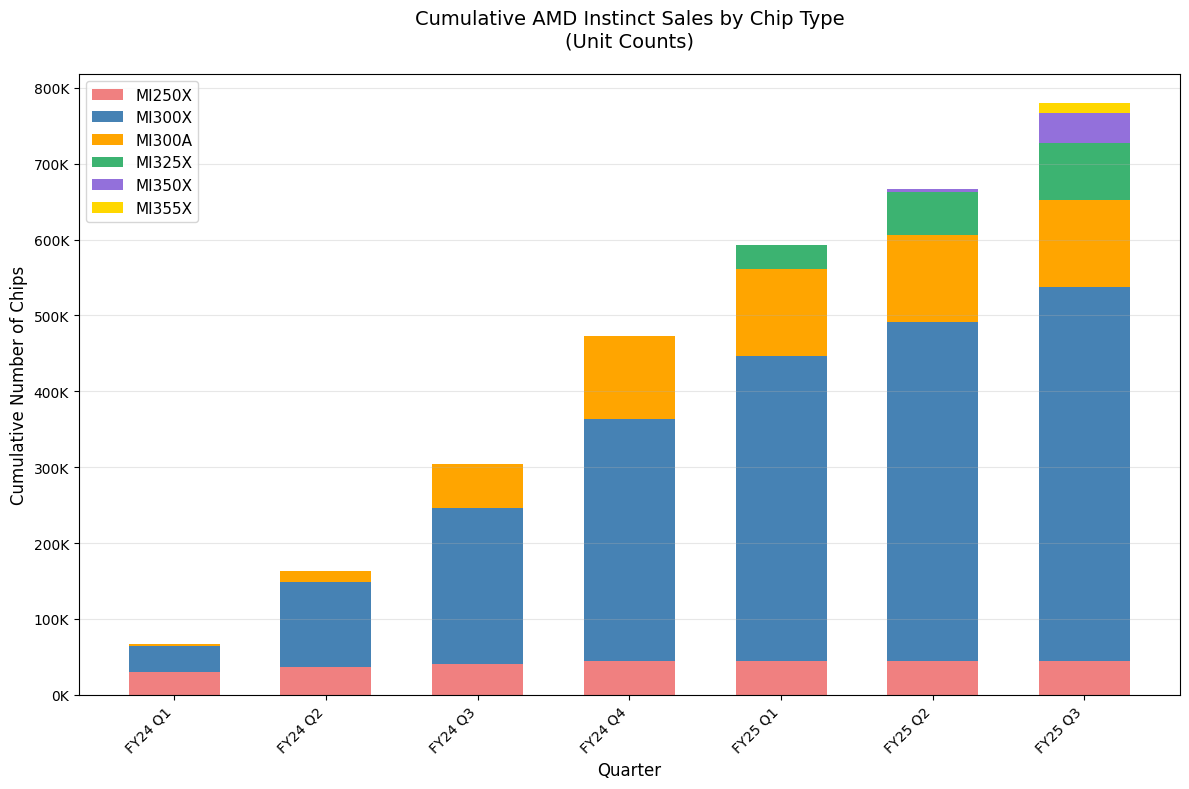

In [74]:
# ==============================================
# VISUALIZATION: CUMULATIVE SALES BY CHIP TYPE (UNIT COUNTS)
# ==============================================

# Colors for each AMD chip type
AMD_COLORS = {
    'MI250X': 'lightcoral',
    'MI300X': 'steelblue',
    'MI300A': 'orange',
    'MI325X': 'mediumseagreen',
    'MI350X': 'mediumpurple',
    'MI355X': 'gold',
}

# Get quarters in order
quarters = list(sim_results.keys())
chip_types = list(AMD_SPECS.keys())

# Calculate median quantities for each chip type by quarter
chip_data = {chip: [] for chip in chip_types}
for quarter in quarters:
    for chip in chip_types:
        arr = np.array(sim_results[quarter][chip])
        chip_data[chip].append(int(np.percentile(arr, 50)))

# --- PLOT 1: Cumulative Unit counts ---
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(quarters))
width = 0.6

# Calculate cumulative sums for each chip type
chip_data_cumulative = {chip: np.cumsum(chip_data[chip]) for chip in chip_types}

bottom = np.zeros(len(quarters))
for chip in chip_types:
    values = chip_data_cumulative[chip]
    if values.sum() > 0:
        ax.bar(x, values, width, label=chip, bottom=bottom, color=AMD_COLORS[chip])
        bottom += values

ax.set_ylabel('Cumulative Number of Chips', fontsize=12)
ax.set_xlabel('Quarter', fontsize=12)
ax.set_title('Cumulative AMD Instinct Sales by Chip Type\n(Unit Counts)', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(quarters, rotation=45, ha='right')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e3:.0f}K'))
ax.grid(True, alpha=0.3, axis='y')
ax.legend(fontsize=11, loc='upper left')

plt.tight_layout()
plt.savefig("visualizations/amd_cumulative_sales_units.png", dpi=300, bbox_inches="tight")
plt.show()

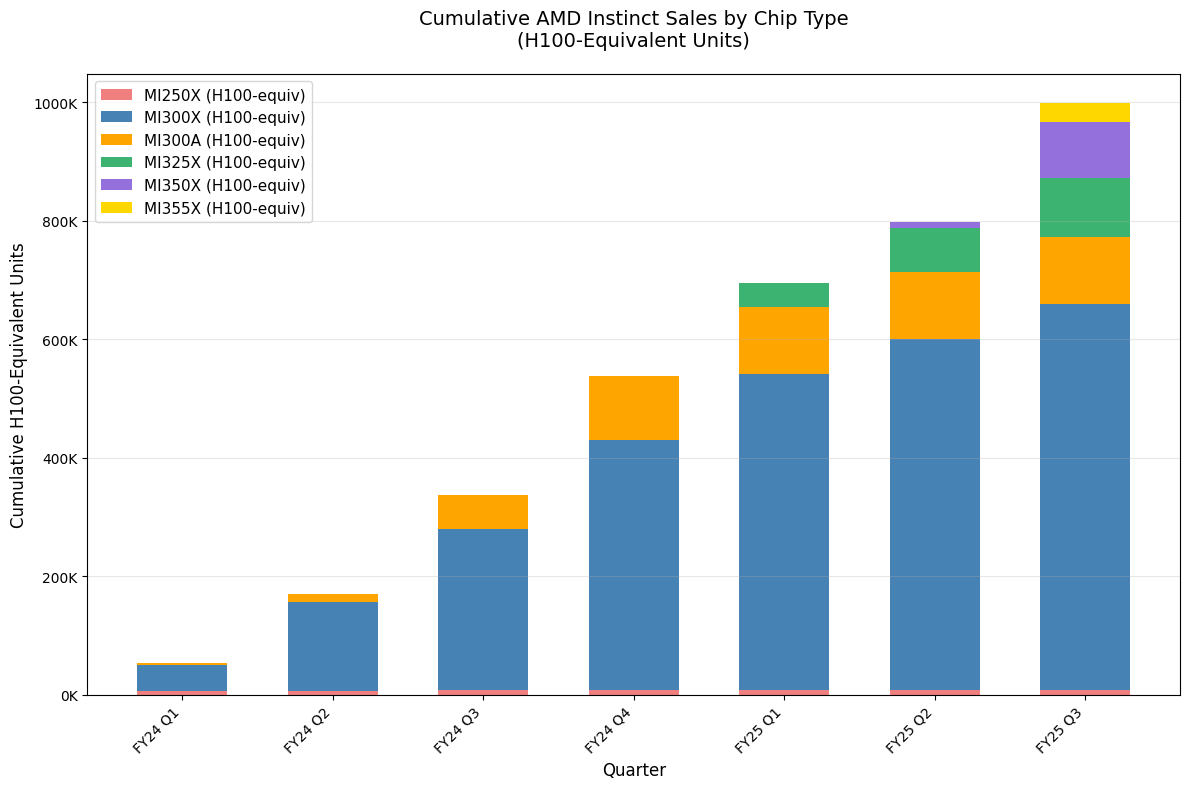

In [75]:
# ==============================================
# VISUALIZATION: CUMULATIVE SALES IN H100-EQUIVALENTS
# ==============================================

# Calculate H100-equivalent quantities for each chip type by quarter
chip_data_h100e = {chip: [] for chip in chip_types}
for quarter in quarters:
    for chip in chip_types:
        arr = np.array(sim_results[quarter][chip])
        h100e_arr = arr * (AMD_SPECS[chip]['tops'] / H100_TOPS)
        chip_data_h100e[chip].append(int(np.percentile(h100e_arr, 50)))

# --- PLOT 2: Cumulative H100-equivalents ---
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(quarters))
width = 0.6

# Calculate cumulative sums for each chip type
chip_data_h100e_cumulative = {chip: np.cumsum(chip_data_h100e[chip]) for chip in chip_types}

bottom = np.zeros(len(quarters))
for chip in chip_types:
    values = chip_data_h100e_cumulative[chip]
    if values.sum() > 0:
        ax.bar(x, values, width, label=f'{chip} (H100-equiv)', bottom=bottom, color=AMD_COLORS[chip])
        bottom += values

ax.set_ylabel('Cumulative H100-Equivalent Units', fontsize=12)
ax.set_xlabel('Quarter', fontsize=12)
ax.set_title('Cumulative AMD Instinct Sales by Chip Type\n(H100-Equivalent Units)', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(quarters, rotation=45, ha='right')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e3:.0f}K'))
ax.grid(True, alpha=0.3, axis='y')
ax.legend(fontsize=11, loc='upper left')

plt.tight_layout()
plt.savefig("visualizations/amd_cumulative_sales_h100e.png", dpi=300, bbox_inches="tight")
plt.show()